In [1]:
import requests
import json
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Задание вытащить все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, подумайте как его обойти)
# Вытащите все описания этих вакансий
# Создайте аналогичный vacancy DataFrame только добавьте поле skills
# Переведите даты публикаций в datetime
# Постройте график опубликованных вакансий по датам
# Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
# Найдите те вакансии с использованием python, которые вам интересны
# Определите по полю skills какие навыки больше всего востребованы для этих вакансий, и
# Постройте график наиболее востребованных вакансий

### Всего чуть более 6 тысяч вакансий на вечер 27 июля 
Максимальное количество, которое можно выгрузить - 2 тысячи.

Выберем 4 временных отрезка, чтобы выгрузить абсолютно все вакансии при помощи атрибутов date_from and date_to

In [3]:
date_list = [('2021-07-23T00:00:00', '2021-07-27T23:59:59'),
             ('2021-07-14T00:00:00', '2021-07-22T23:59:59'),
             ('2021-07-02T00:00:00', '2021-07-13T23:59:59'),
             ('2021-06-01T00:00:00', '2021-07-01T23:59:59')]

### Вытащим все вакансии

In [4]:
%%time
#создаем пустой df
df_with_vacs = pd.DataFrame()

#цикл по каждому временному отрезку, который был выбран ранее
for date_from, date_to in date_list:
    sber = '3529'
    page = 1
    num_per_page = 100
    moscow = 113
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}&date_from={date_from}&date_to={date_to}&order_by=publication_time'
    res = requests.get(url)
    
    #получаем количество страниц в выбранном временном отрезке
    number_of_pages_in_period = res.json().get('pages')
    for i in range(number_of_pages_in_period): # цикл с перебором всех страниц в периоде
        url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}&area={moscow}&date_from={date_from}&date_to={date_to}&order_by=publication_time'
        res = requests.get(url)
        vacancies = res.json()
        
        #добавляем вакансии накопительным итогом
        df_with_vacs = df_with_vacs.append(pd.DataFrame(vacancies.get('items')))
        
df_with_vacs.reset_index(inplace=True)

Wall time: 35.5 s


In [13]:
#dump(df_with_vacs, 'df_with_vacs.joblib')
#df_with_vacs = load('df_with_vacs.joblib')

In [14]:
print(len(df_with_vacs))

6025


In [15]:
df_with_vacs.head(2)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,week_day
0,45654914,False,"Senior Linux Engineer, трайб Global Trading Pl...","{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новоданиловская ...",...,"{'id': '3529', 'name': 'Сбербанк', 'url': 'htt...",{'requirement': 'Требуемые навыки: Ключевой Li...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,1
1,45656128,False,Инженер поддержки торговых систем/Application ...,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новоданиловская ...",...,"{'id': '3529', 'name': 'Сбербанк', 'url': 'htt...",{'requirement': 'Ø Опыт работы в сопровождении...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,1


### Получим описание вакансии

Может был и другой способ, но я сделал по-простому. По каждому id делал запрос vacancies/{vacancy_id} Результат добавлял в list

In [ ]:
%%time
full_vacancy_description_list = []
for id in df_with_vacs.id:
    try:
        full_vacancy_description_list.append(requests.get(f'https://api.hh.ru/vacancies/{id}').json())
    except:
        print(f'cant get description for id {id}')
        
#df_with_vacs['full_vacancy_description_list'] = full_vacancy_description_list
#dump(df_with_vacs, 'df_with_vacs_with_description.joblib')
#dump(full_vacancy_description_list, 'full_vacancy_description_list.joblib')

In [8]:
print(len(full_vacancy_description_list))

6025


In [29]:
full_vacancy_description_list[0]

{'id': '45654914',
 'premium': False,
 'billing_type': {'id': 'standard', 'name': 'Стандарт'},
 'relations': [],
 'name': 'Senior Linux Engineer, трайб Global Trading Platform',
 'insider_interview': None,
 'response_letter_required': False,
 'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
 'salary': None,
 'type': {'id': 'open', 'name': 'Открытая'},
 'address': {'city': 'Москва',
  'street': 'Новоданиловская набережная',
  'building': '10',
  'description': None,
  'lat': 55.695905,
  'lng': 37.625361,
  'raw': 'Москва, Новоданиловская набережная, 10',
  'metro': {'station_name': 'Тульская',
   'line_name': 'Серпуховско-Тимирязевская',
   'station_id': '9.142',
   'line_id': '9',
   'lat': 55.70961,
   'lng': 37.622569},
  'metro_stations': [{'station_name': 'Тульская',
    'line_name': 'Серпуховско-Тимирязевская',
    'station_id': '9.142',
    'line_id': '9',
    'lat': 55.70961,
    'lng': 37.622569}]},
 'allow_messages': True,
 'site': {'id': 'hh', 'name

### Изменить type на datetime

In [17]:
df_with_vacs.published_at = df_with_vacs.published_at.astype('datetime64[ns]')
df_with_vacs.published_at.iloc[0]

Timestamp('2021-07-27 17:26:25')

### Постройте график опубликованных вакансий по датам

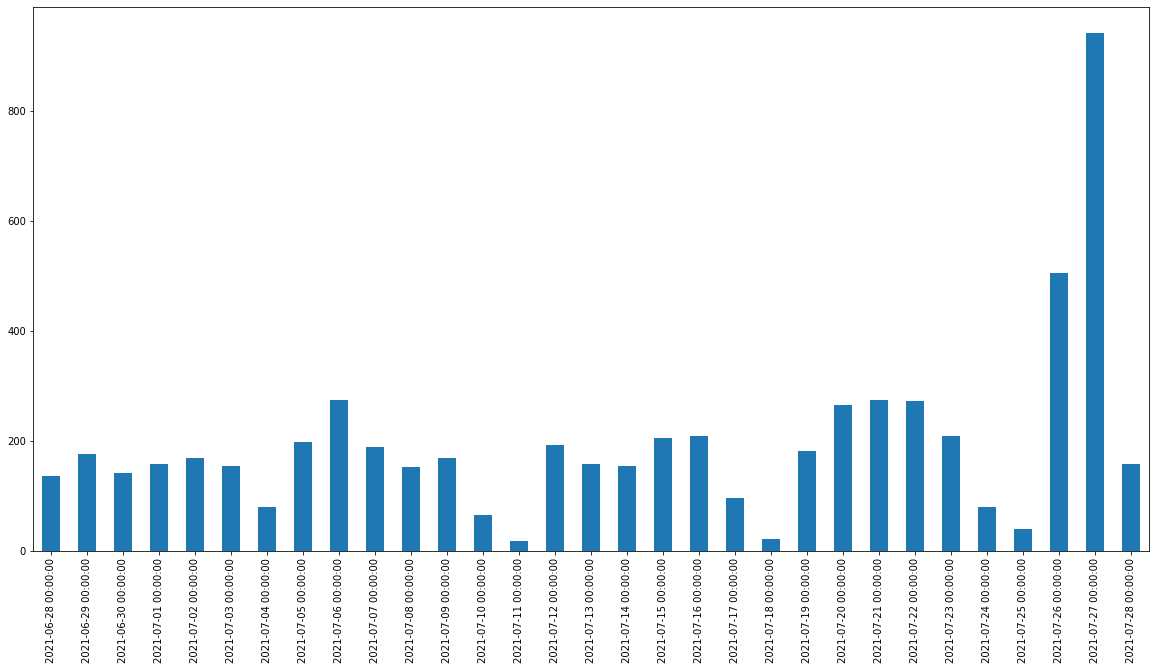

In [18]:
plt.figure(figsize=(20,10))
df_with_vacs.published_at.dt.round('D').value_counts().sort_index().plot(kind='bar')
plt.show()

Больше всего открытых вакансий были опубликованы в течение двух предыдущих дней.

Получается, что большинство вакансий закрываются в первые дни после публикации

### Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий

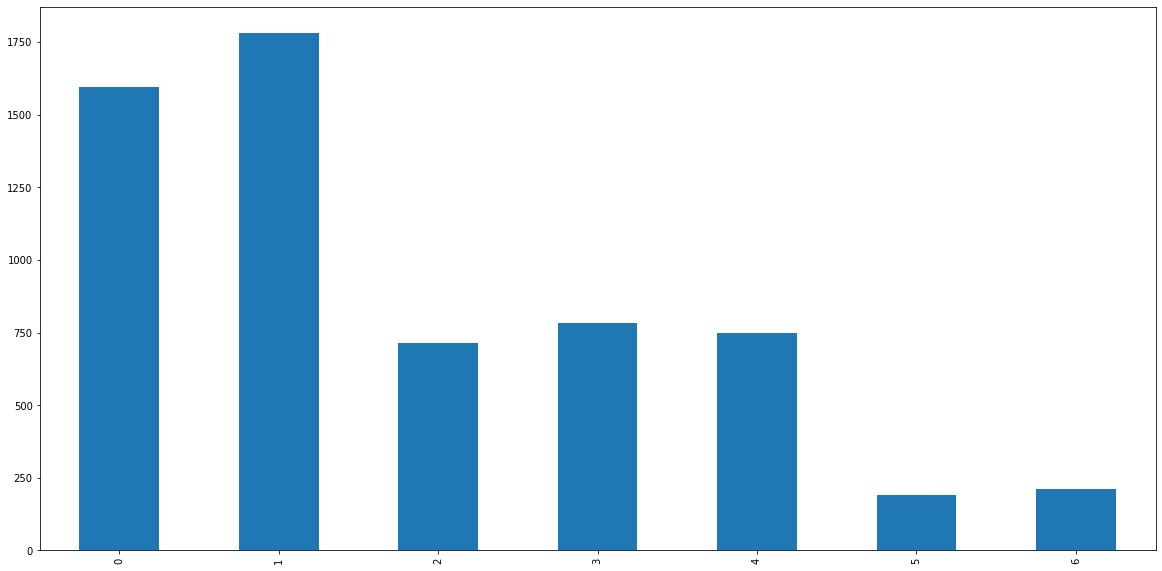

In [19]:
df_with_vacs['week_day'] = df_with_vacs.published_at.apply(lambda x: x.weekday())
plt.figure(figsize=(20,10))
df_with_vacs.week_day.value_counts().sort_index().plot(kind='bar')
plt.show()

0 - Понедельник

6 - воскресенье

Таким образом, больше всего вакансий появляется в понедельник/вторник

### Найдите те вакансии с использованием python, которые вам интересны

Допустим, что все вакансии у которых в snippet['requirement'] есть python мне интересны

In [20]:
df_with_vacs['requirement'] = df_with_vacs.snippet.apply(lambda x: x['requirement'])
df_with_vacs['requirement'].fillna('', inplace=True)
df_with_vacs['vac_with_python'] = df_with_vacs.requirement.apply(lambda x: 'python' in x)

In [22]:
df_with_vacs[df_with_vacs['vac_with_python'] == True].head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,week_day,requirement,vac_with_python
1176,45919676,False,ML Engineer (Массовая персонализация),"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,0,Опыт разработки на python. Понимание принципов...,True
1180,46523580,False,QA automation engineer/Инженер по автоматизаци...,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,0,Опыт автоматизации тестирования API. Опыт нагр...,True
1300,45674132,False,DevOps инженер (SberDevices),"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,0,"Навыки работы в Linux, bash. Работа с docker, ...",True
1359,46510361,False,Python-разработчик,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '66', 'name': 'Нижний Новгород', 'url':...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,0,"Уверенное знание python, опыт разработки сетев...",True
1408,46257924,False,Python-разработчик в SberDevices (core-навык г...,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,0,Имеете коммерческий опыт разработки на python ...,True


### Определите по полю skills какие навыки больше всего востребованы для этих вакансий, и

Поле skills, или key_skills, находится в полном описании вакансии

In [23]:
liked_vacs_id_list = list(df_with_vacs[df_with_vacs['vac_with_python'] == True].id)

In [24]:
required_skills = []
for full_vacancy_description in full_vacancy_description_list:
    if full_vacancy_description['id'] in liked_vacs_id_list:
        required_skills.append(full_vacancy_description['key_skills'])
    

In [25]:
list(filter(lambda x: x != [], required_skills))

[[{'name': 'Linux'},
  {'name': 'Java'},
  {'name': 'Bash'},
  {'name': 'Jenkins'},
  {'name': 'Docker'},
  {'name': 'Ansible'},
  {'name': 'C/C++'},
  {'name': 'Python'},
  {'name': 'Groovy'}],
 [{'name': 'Python'},
  {'name': 'SQL'},
  {'name': 'PostgreSQL'},
  {'name': 'Git'}],
 [{'name': 'Python'},
  {'name': 'Git'},
  {'name': 'Linux'},
  {'name': 'Docker'},
  {'name': 'SQL'}],
 [{'name': 'ELK'},
  {'name': 'Python'},
  {'name': 'JavaScript'},
  {'name': 'SQL'}],
 [{'name': 'Linux'},
  {'name': 'Java'},
  {'name': 'Bash'},
  {'name': 'Jenkins'},
  {'name': 'Docker'},
  {'name': 'Ansible'},
  {'name': 'C/C++'},
  {'name': 'Python'},
  {'name': 'Groovy'}]]

### Постройте график наиболее востребованных вакансий

Попробуем посчитать количество самых востребованных вакансий по имени.

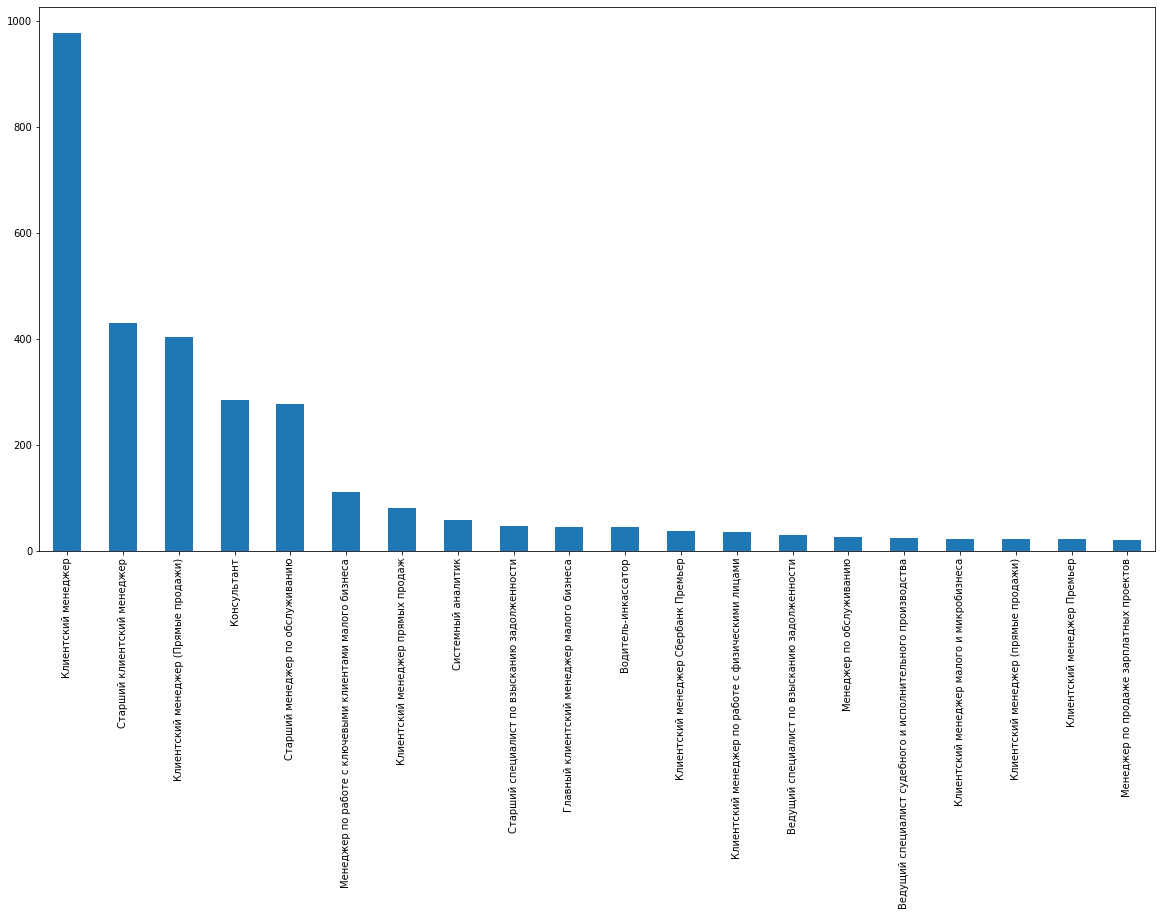

Клиентский менеджер                                            977
Старший клиентский менеджер                                    429
Клиентский менеджер (Прямые продажи)                           404
Консультант                                                    285
Старший менеджер по обслуживанию                               277
Менеджер по работе с ключевыми клиентами малого бизнеса        110
Клиентский менеджер прямых продаж                               81
Системный аналитик                                              57
Старший специалист по взысканию задолженности                   46
Главный клиентский менеджер малого бизнеса                      45
Водитель-инкассатор                                             44
Клиентский менеджер Сбербанк Премьер                            37
Клиентский менеджер по работе с физическими лицами              36
Ведущий специалист по взысканию задолженности                   30
Менеджер по обслуживанию                                      

In [26]:
plt.figure(figsize=(20,10))

df_with_vacs.name.value_counts()[:20].plot(kind='bar')
plt.show()
print(df_with_vacs.name.value_counts()[:20])